# Collaboration and Competition (Using the MADDPG Algorithm)

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


Run the next code cell to install `progressbar`: a library to provide visual (text-based) progress to long running operations.

In [2]:
!pip -q install progressbar

Run the next code cell to install `torchviz`: a package to create visualizations of PyTorch execution graphs.

In [3]:
!pip -q install torchviz

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [4]:
# Load the shared hyperparameters.
from maddpg.hyperparams import *

In [5]:
import numpy as np
np.random.seed(RANDOM_SEED)

import random
random.seed(RANDOM_SEED)

import torch
torch.manual_seed(RANDOM_SEED)

In [6]:
# Import the progressbar package.
import progressbar as pb

# Other imports.
from collections import deque

In [7]:
from unityagents import UnityEnvironment

# Load the environment.
env = UnityEnvironment(seed=RANDOM_SEED, file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [8]:
# Get the default brain.
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [9]:
# Reset the environment.
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents.
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# Size of each action.
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# Examine the state space.
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [10]:
for i in range(5):                                         # Play game for 5 episodes.
    env_info = env.reset(train_mode=False)[brain_name]     # Reset the environment.
    states = env_info.vector_observations                  # Get the current state (for each agent).
    scores = np.zeros(num_agents)                          # Initialize the score (for each agent).
    while True:
        actions = np.random.randn(num_agents, action_size) # Select an action (for each agent).
        actions = np.clip(actions, -1, 1)                  # All actions between -1 and 1.
        env_info = env.step(actions)[brain_name]           # Send all actions to tne environment.
        next_states = env_info.vector_observations         # Get next state (for each agent).
        rewards = env_info.rewards                         # Get reward (for each agent).
        dones = env_info.local_done                        # See if episode finished.
        scores += env_info.rewards                         # Update the score (for each agent).
        states = next_states                               # Roll over states to next time step.
        if np.any(dones):                                  # Exit loop if episode finished.
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

#### Obtain NVIDIA GPU Information

In [11]:
# Set the working device on the NVIDIA Tesla K80 accelerator GPU (depending on availability).
# Otherwise we use the CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', str(device).upper())
print()

# Log additional info (when using the NVIDIA Tesla K80 accelerator).
# See <https://www.nvidia.com/en-gb/data-center/tesla-k80/>.
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: CUDA

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [12]:
# torchviz imports.
from torch.autograd import Variable
from torchviz import make_dot, make_dot_from_trace

#### Inspect the Model

In [13]:
# # Load the Actor.
# from maddpg.model import Actor

# actor = Actor(state_size, action_size)
# x = Variable(torch.randn(1, state_size))
# y = actor(x)

# dot = make_dot(y, params=dict(list(actor.named_parameters())))

# print(dot)

# dot.format = 'png'
# dot.render("Actor")

In [14]:
# # Load the Critic.
# from maddpg.model import Critic

# critic = Critic(state_size, action_size)
# x = Variable(torch.randn(1, state_size))
# z = Variable(torch.randn(1, action_size))
# y = critic(x, z)

# dot = make_dot(y, params=dict(list(critic.named_parameters())))

# print(dot)

# dot.format = 'png'
# dot.render("Critic")

In [15]:
# Load the MADDPG wrapper.
from maddpg.wrapper import Wrapper

# Load the helper functions.
from maddpg.main import train, test, plot

In [16]:
# This will print the model arch.
maddpg = Wrapper(NUM_AGENTS, STATE_SIZE, ACTION_SIZE)

Agent [#1]

Actor (Local):
Actor(
  (fc1): Linear(in_features=24, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=2, bias=True)
)
Actor (Target):
Actor(
  (fc1): Linear(in_features=24, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=2, bias=True)
)
Critic (Local):
Critic(
  (fcs1): Linear(in_features=52, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=1, bias=True)
)
Critic (Target):
Critic(
  (fcs1): Linear(in_features=52, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=1, bias=True)
)
_______________________________________________________________

Agent [#2]

Actor (Local):
Actor(
  (fc1): Linear(in_features=24, out_features=200, bia

In [17]:
import time

# Monitor training time (start time).
start_time = time.time()

# Train the MADDPG model.
total_scores, rolling_avgs = train(maddpg, env)

# Monitor training time (end time).
end_time = (time.time()-start_time)/6e1

# Log the runtime.
print("\nTotal runtime {:.2f} minutes.".format(end_time))


Environment solved in 2294 episodes...	Average score: 0.50


Model saved successfully.


Model updated successfully.


Model updated successfully.


Model updated successfully.

Total runtime 120.13 minutes.


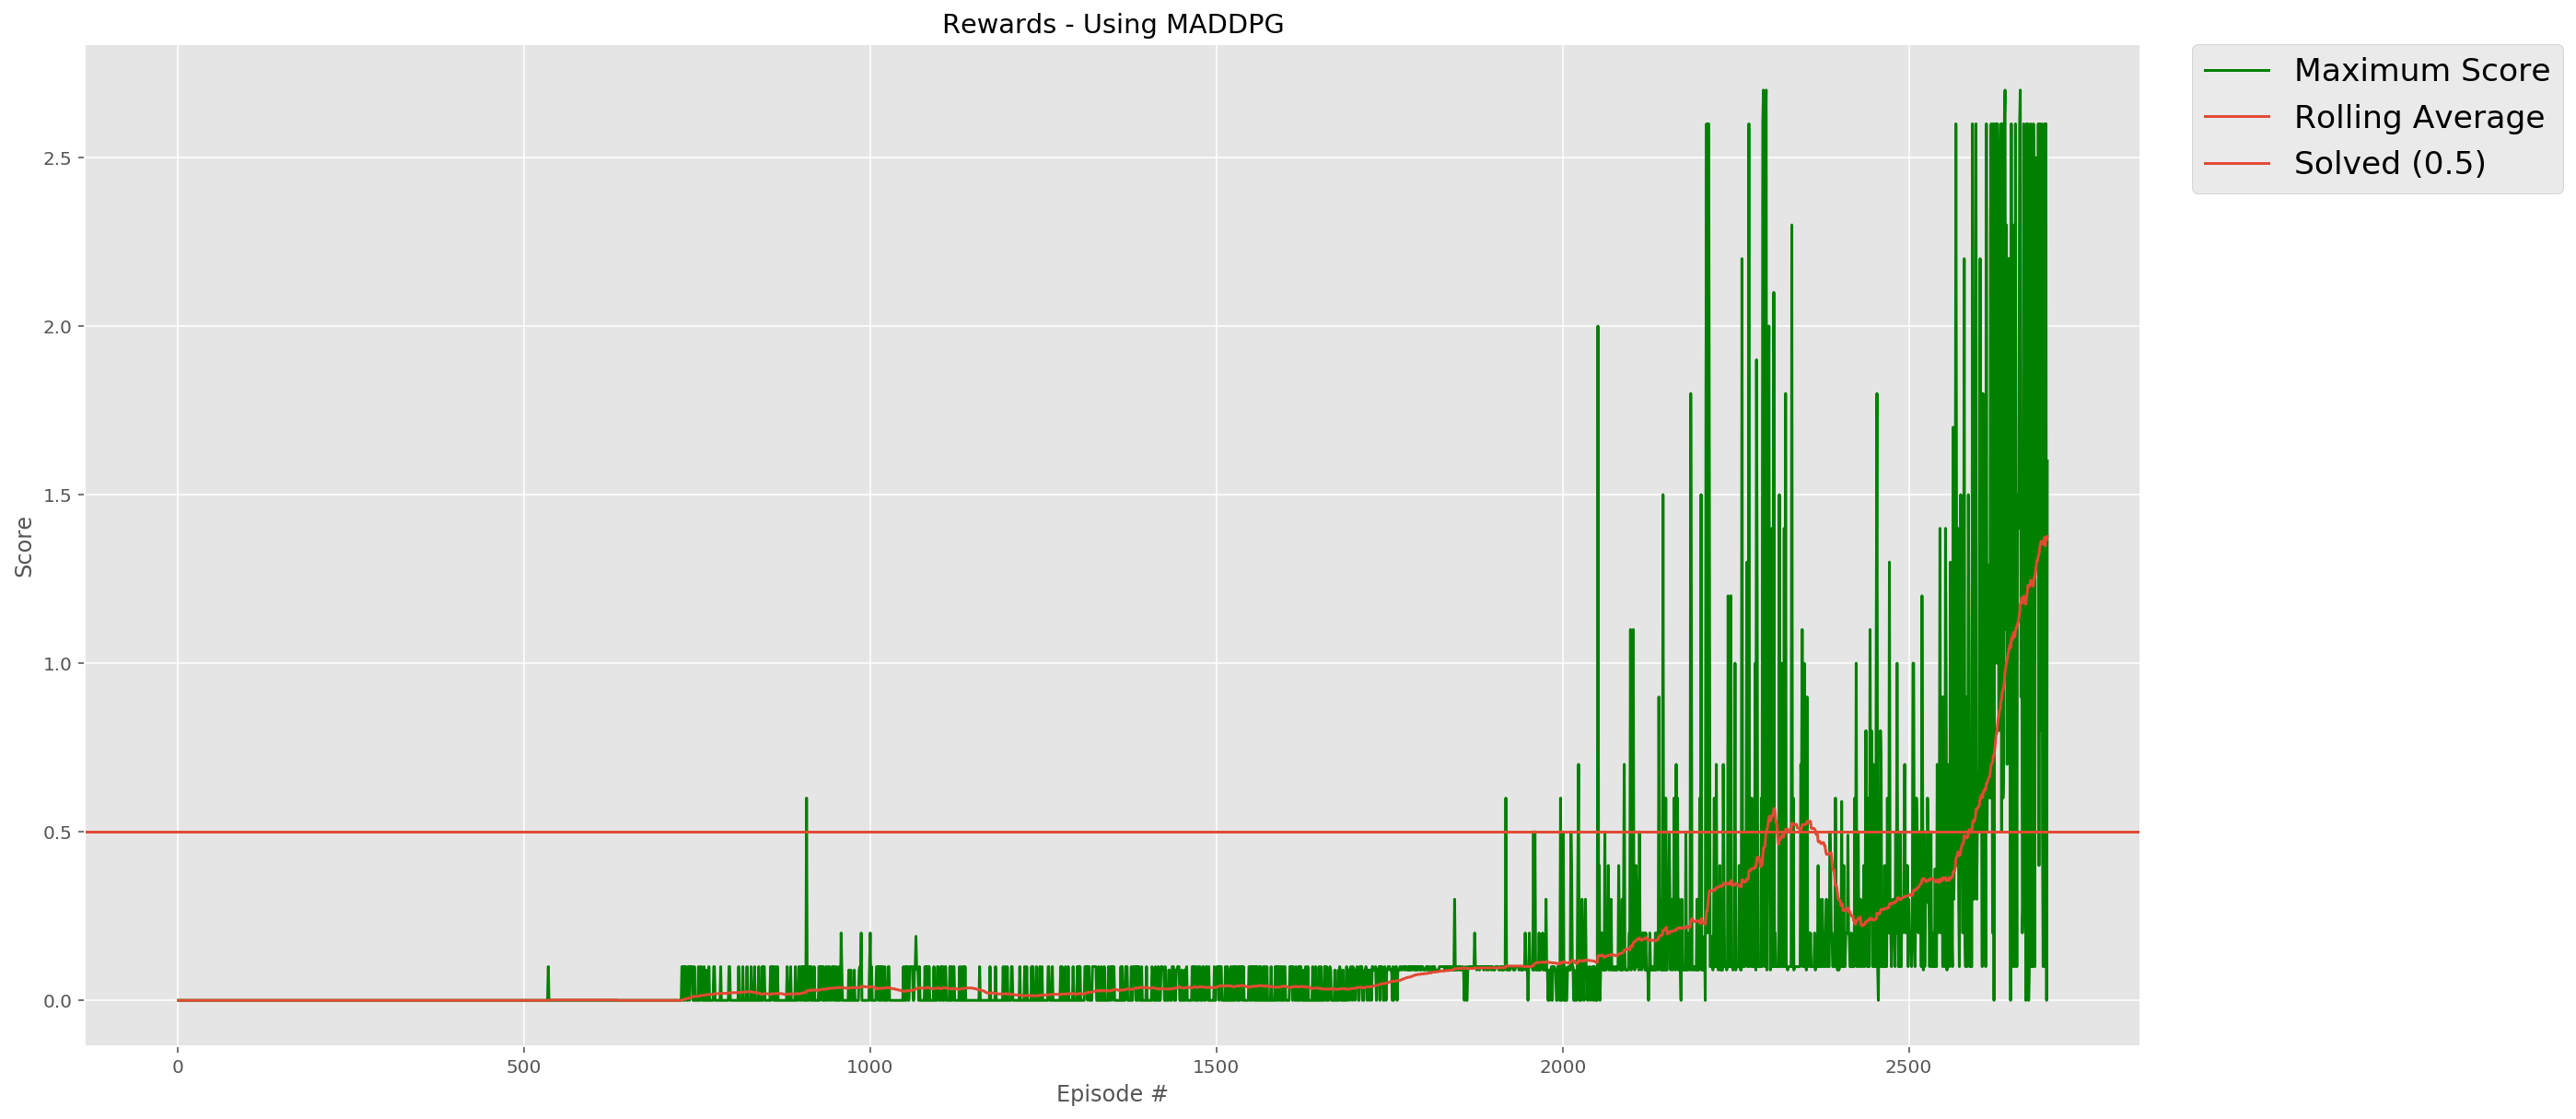

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# High-resolution plots for retina displays.
%config InlineBackend.figure_format = 'retina'

# Plot the scores using matplotlib.
plt.style.use('ggplot')

# Plot the results.
plot(total_scores, rolling_avgs)

In [19]:
# Test the MADDPG model.
test(maddpg, env, load_from_file=False)

Agent [0]: Red Racket.
Agent [1]: Blue Racket.


Partial gameplay score: [1, 0]

Partial gameplay score: [1, 1]

Partial gameplay score: [1, 2]

Partial gameplay score: [2, 2]

Partial gameplay score: [3, 2]

Partial gameplay score: [3, 3]

Partial gameplay score: [3, 4]

Partial gameplay score: [3, 5]

Partial gameplay score: [3, 6]

Partial gameplay score: [4, 6]

Agent #1 Won!


When finished, you can close the environment.

In [21]:
env.close()